# `pd.read_sql_query`

Confirming that we're using the right environment:

In [1]:
import os
import pymysql
import pandas as pd
print(os.environ['CONDA_DEFAULT_ENV'])

pedagogy


In [240]:
host = os.getenv('MYSQL_HOST')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user=user,
    passwd=password,
    db=database)

df = pd.read_sql_query("SELECT * FROM workshop", conn, index_col='id')
# convert datetime to '2018-09' month and year format
df['mnth_yr'] = df.workshop_start.dt.to_period('M')
df.tail(5)

,workshop_name,workshop_category,workshop_instructor,workshop_start,workshop_hours,workshop_venue,class_size,mnth_yr
id,,,,,,,,
36,Deragon P4DS,Academy,1,2018-07-30 18:00:00,9,Block 71,23,2018-07
37,Chronos PS,Academy,5,2018-06-28 18:00:00,9,Block 71,18,2018-06
38,Chronos PS,Academy,16,2018-06-28 18:00:00,9,Connext,13,2018-06
39,Chronos Deragon C1,Academy,1,2018-08-14 18:00:00,9,Block 71,23,2018-08
40,Chronos Deragon C1,Academy,9,2018-08-14 18:00:00,9,Aston Hotel,16,2018-08


## Data Visualization

In [208]:
df['this_user'] = df['workshop_instructor'] == 1
dat = df.loc[:,['this_user', 'class_size']]
dat.head()

,this_user,class_size
id,,
1,True,21
2,True,30
3,True,12
4,True,29
5,True,5


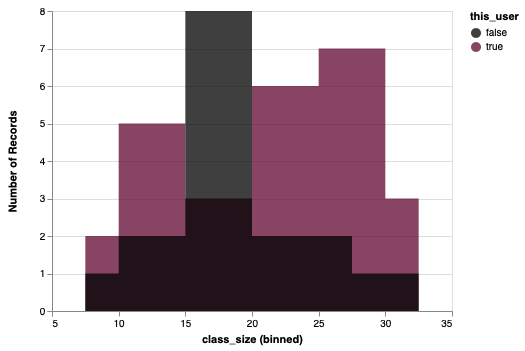

In [209]:
import altair as alt

alt.Chart(dat).mark_area(
    opacity=0.75,
    interpolate='step'
).encode(
    alt.X("class_size:Q", bin=alt.Bin(maxbins=12)),
    alt.Y('count()', stack=None),
    alt.Color(
        'this_user',
        scale=alt.Scale(range=['#000000', '#62092f'])
    )
)

In [210]:
dat = df.loc[df.this_user==True, ['workshop_hours', 'mnth_yr', 'workshop_category', 'class_size']]
# mnth_yr needs to be a string instead of Period
dat['mnth_yr'] = df['mnth_yr'].astype(str)
dat.head()

,workshop_hours,mnth_yr,workshop_category,class_size
id,,,,
1,9,2017-08,DSS,21
2,9,2017-09,DSS,30
3,9,2017-10,DSS,12
4,9,2017-10,DSS,29
5,18,2017-10,Corporate,5


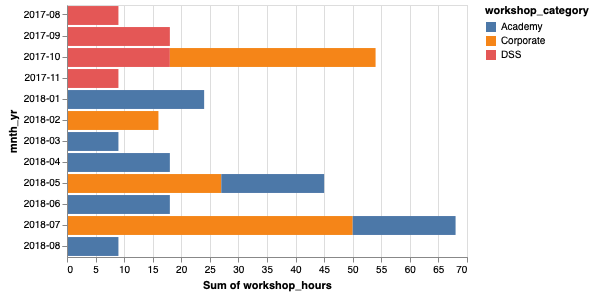

In [211]:
alt.Chart(dat).mark_bar().encode(
    alt.X("sum(workshop_hours)"),
    alt.Y('mnth_yr'),
    alt.Color('workshop_category')
)

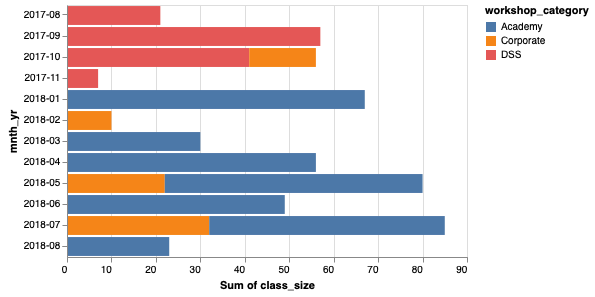

In [212]:
alt.Chart(dat).mark_bar().encode(
    alt.X("sum(class_size)"),
    alt.Y('mnth_yr'),
    alt.Color('workshop_category')
)

In [213]:
# transform to [mnth_yr, 'workshop_category', 'variable', 'value']
# perform a Trellis Stacked Bar Chart later
melted = pd.melt(dat, 
              id_vars=['mnth_yr', 'workshop_category'], 
              value_vars=['workshop_hours', 'class_size'])
melted.head()

,mnth_yr,workshop_category,variable,value
0,2017-08,DSS,workshop_hours,9
1,2017-09,DSS,workshop_hours,9
2,2017-10,DSS,workshop_hours,9
3,2017-10,DSS,workshop_hours,9
4,2017-10,Corporate,workshop_hours,18


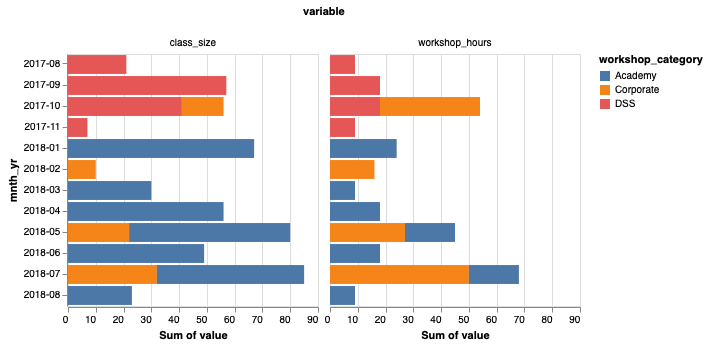

In [214]:
alt.Chart(melted).mark_bar().encode(
    column='variable',
    x=alt.X("sum(value)"),
    y=alt.Y('mnth_yr'),
    color=alt.Color('workshop_category')
).properties(
    width=250
)

In [215]:
df['workshop_category'] = df['workshop_category'].astype('category')
df['workshop_category'] = pd.Categorical(df['workshop_category']).codes
df.head()

,workshop_name,workshop_category,workshop_instructor,workshop_start,workshop_hours,workshop_venue,class_size,mnth_yr,this_user
id,,,,,,,,,
1,Data Science Fundamentals ML Aug 17,2,1,2017-08-15 18:00:00,9,Base Cowork Lounge,21,2017-08,True
2,Data Science Fundamentals ML Sep 17,2,1,2017-09-27 18:00:00,9,Base Cowork Lounge,30,2017-09,True
3,Data Science Fundamentals DV Oct 17,2,1,2017-10-10 18:00:00,9,Block 71,12,2017-10,True
4,Data Science Fundamentals ML Oct 17,2,1,2017-10-23 18:00:00,9,Block 71,29,2017-10,True
5,PT SPIL 2017,1,1,2017-10-17 10:00:00,18,"PT. SPIL, Surabaya",5,2017-10,True


In [217]:
dat = df.set_index('workshop_start').resample('W').sum()
dat.head()

,workshop_category,workshop_instructor,workshop_hours,class_size,this_user
workshop_start,,,,,
2017-08-20,2,1,9,21,1.0
2017-08-27,0,0,0,0,0.0
2017-09-03,0,0,0,0,0.0
2017-09-10,0,0,0,0,0.0
2017-09-17,2,1,9,27,1.0


In [218]:
melted = pd.melt(dat.reset_index(), 
              id_vars=['workshop_start','workshop_category'], 
              value_vars=['workshop_hours', 'class_size'])
melted.head()

,workshop_start,workshop_category,variable,value
0,2017-08-20,2,workshop_hours,9
1,2017-08-27,0,workshop_hours,0
2,2017-09-03,0,workshop_hours,0
3,2017-09-10,0,workshop_hours,0
4,2017-09-17,2,workshop_hours,9


In [219]:
melted['workshop_category'] = melted['workshop_category'].apply(lambda x: 'Public' if (x == 0 | x == 2) else 'Corporate' )
melted['cumsum'] = melted.groupby(['variable','workshop_category']).cumsum().fillna(0)
melted[melted.workshop_category == "Public"].head()

,workshop_start,workshop_category,variable,value,cumsum
0,2017-08-20,Public,workshop_hours,9,9
4,2017-09-17,Public,workshop_hours,9,18
8,2017-10-15,Public,workshop_hours,9,27
10,2017-10-29,Public,workshop_hours,9,36
14,2017-11-26,Public,workshop_hours,9,45


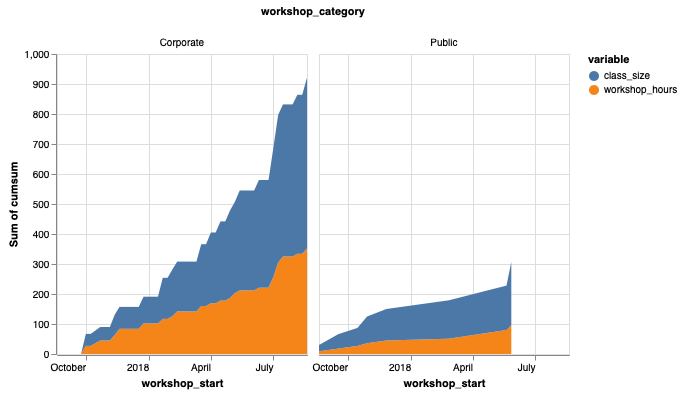

In [220]:
alt.Chart(melted).mark_area().encode(
    column='workshop_category',
    x=alt.X("workshop_start"),
    y=alt.Y("sum(cumsum)"),
    color=alt.Color("variable")
).properties(
    width=250
)

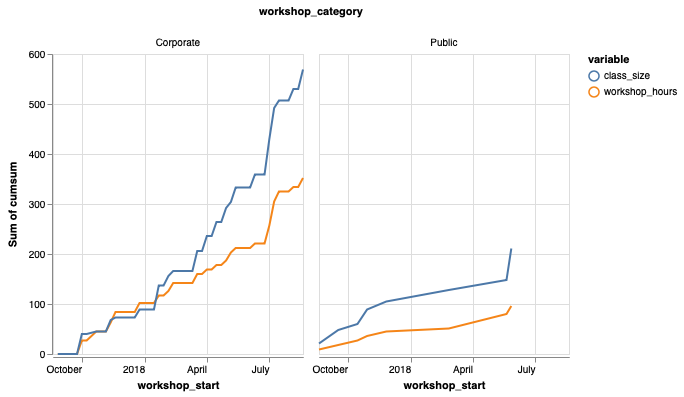

In [221]:
alt.Chart(melted).mark_line().encode(
    column='workshop_category',
    x=alt.X("workshop_start"),
    y=alt.Y("sum(cumsum)"),
    color=alt.Color("variable")
).properties(
    width=250
)

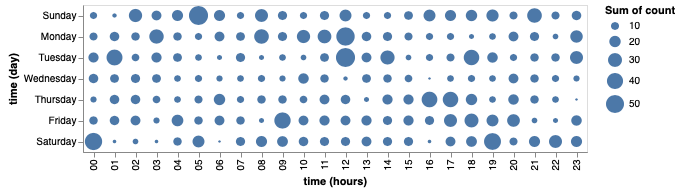

In [195]:
source = data.github.url

alt.Chart(source).mark_circle().encode(
    x='hours(time):O',
    y='day(time):O',
    size='sum(count):Q'
)

In [198]:
github = pd.read_csv(source)
github.head()

,time,count
0,2015/01/01 01:00:00,2
1,2015/01/01 04:00:00,3
2,2015/01/01 05:00:00,1
3,2015/01/01 08:00:00,1
4,2015/01/01 09:00:00,3


In [247]:
df['mnth_yr'] = df['mnth_yr'].astype(str)
df['workshop_category'] = df['workshop_category'].apply(lambda x:x if x == 'Corporate' else 'Public' )
df['contrib'] = df['workshop_hours'] * df['class_size']
df.head(7)

,workshop_name,workshop_category,workshop_instructor,workshop_start,workshop_hours,workshop_venue,class_size,mnth_yr,contrib
id,,,,,,,,,
1,Data Science Fundamentals ML Aug 17,Public,1,2017-08-15 18:00:00,9,Base Cowork Lounge,21,2017-08,189
2,Data Science Fundamentals ML Sep 17,Public,1,2017-09-27 18:00:00,9,Base Cowork Lounge,30,2017-09,270
3,Data Science Fundamentals DV Oct 17,Public,1,2017-10-10 18:00:00,9,Block 71,12,2017-10,108
4,Data Science Fundamentals ML Oct 17,Public,1,2017-10-23 18:00:00,9,Block 71,29,2017-10,261
5,PT SPIL 2017,Corporate,1,2017-10-17 10:00:00,18,"PT. SPIL, Surabaya",5,2017-10,90
6,Bank Sinarmas 2017,Corporate,4,2017-12-18 13:00:00,18,Sinarmas Roxy Learning Center,16,2017-12,288
7,PT KLK 2017,Corporate,6,2017-11-13 13:00:00,21,KLK Agriservindo Sunter,5,2017-11,105


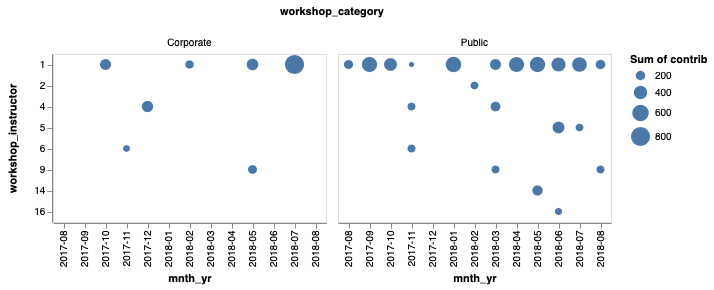

In [248]:
alt.Chart(df).mark_circle().encode(
    x='mnth_yr:O',
    y='workshop_instructor:O',
    size='sum(contrib):Q',
    column='workshop_category:O'
)